This notebook compares the scores of the local models and the model chain

In [32]:
import numpy as np
import pandas as pd
#import itertools 
#import random

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import r2_score, accuracy_score
from permutation_importance import Chain
import os

In [2]:
def missingness_stratified_cv(df, N_FOLDS=5, random_state=None):
    # Add seed for reproducibility of the predictions (to get the same scores each time we run the code)
    np.random.seed(random_state)

    # Initial complete-case test fold assignment
    cv = pd.Series(np.nan, index=df.index)
    i_cc = (df.isna().sum(axis=1) == 0) # Complete cases
    cv.iloc[i_cc] = np.random.randint(low=0, high=N_FOLDS, size=i_cc.sum())

    # Go over columns from most missing to least missing
    for j in df.isna().sum().argsort()[::-1]:
        # Instances i that are not assigned yet but for which df[i,j] is observed
        i_tbf = (cv.isna()) & (~df.iloc[:,j].isna()) # to be filled
        # Fill them randomly
        cv.iloc[i_tbf] = np.random.randint(low=0, high=N_FOLDS, size=i_tbf.sum())

    return cv

In [3]:
possible_paths = [
    'C:/Users/lenne/OneDrive/Documenten/Master of Statistics and Data Science/2023-2024/Master thesis/Thesis_Sofia_Lennert/new_data',
    'C:/Users/anaso/Desktop/SOFIA MENDES/KU Leuven/Master Thesis/Thesis_Sofia_Lennert/new_data'
]

# Define file names
file = 'merged_data.csv'

# Find full paths to the CSV files
path = next((f'{path}/{file}' for path in possible_paths if os.path.exists(f'{path}/{file}')), None)

data = pd.read_csv(path)

# Bin the number of relapses into 0, 1, 2, 3 and 4+ 
def bin_column(value):
    if value in [0, 1, 2, 3]:
        return str(value)
    else:
        return '4+'
data['NRELAP'] = data['NRELAP'].apply(bin_column)

# Resulting DataFrame will have aggregated data from all four datasets based on the specific_column
pd.set_option('display.max_columns', None)
data

,USUBJID,AGE,SEX,RACE,CONTINENT,CESEV,CECONTRT,TOTRELAP,MHCONTRT,MHDIAGN,CARDIO,URINARY,MUSCKELET,FATIGUE,SMSTDY,NRELAP,NHPT-before,NHPT-2y,NHPT-after_2y,PASAT_2s-before,PASAT_2s-2y,PASAT_2s-after_2y,PASAT_3s-before,PASAT_3s-2y,PASAT_3s-after_2y,SDMT-before,SDMT-2y,T25FW-before,T25FW-2y,T25FW-after_2y,T-before,T-after,P-before,P-after,N-before,N-after,DS,DS_L,DS_R,SLEC_before,SLEC_after,SES_after,SES_before,VAA,BDI-before,BDI-after,EDSS-before,EDSS-2y,EDSS-after_2y,KFSS1-Sensory-2y,KFSS1-Sensory-after_2y,KFSS1-Sensory-before,KFSS1-Brain-2y,KFSS1-Brain-after_2y,KFSS1-Brain-before,KFSS1-Bowel-2y,KFSS1-Bowel-after_2y,KFSS1-Bowel-before,KFSS1-Pyramidal-2y,KFSS1-Pyramidal-after_2y,KFSS1-Pyramidal-before,KFSS1-Cerebral-2y,KFSS1-Cerebral-after_2y,KFSS1-Cerebral-before,KFSS1-Visual-2y,KFSS1-Visual-after_2y,KFSS1-Visual-before,KFSS1-Cerebellar-2y,KFSS1-Cerebellar-after_2y,KFSS1-Cerebellar-before,KFSS_M-2y,KFSS_M-after_2y,KFSS_M-before,KFSS_P-2y,KFSS_P-after_2y,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,M_R36-SF12-after,P_R36-SF12-after,R36-SF12-after_Ind
0,MSOAC/0649,NaN,F,WHITE,NORTH AMERICA,NaN,NaN,NaN,Y,SPMS,0,1,0,1,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.35,10.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MSOAC/2224,38.0,F,WHITE,EUROPE,NaN,NaN,NaN,NaN,RRMS,0,1,0,0,NaN,0.0,27.80,26.55,NaN,NaN,NaN,NaN,55.0,56.0,NaN,38.0,42.0,8.90,8.85,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,30.0,30.0,1.25,1.25,NaN,0.380952,0.388889,3.00,3.0,NaN,0.000000,NaN,0.000000,0.2,NaN,0.2,0.000000,NaN,0.000000,0.5,NaN,0.500000,0.0,NaN,0.0,0.000000,NaN,0.0,0.0,NaN,0.0,0.148148,NaN,0.148148,0.000000,NaN,0.000000,0.733333,0.653846,0.0,0.566667,0.576923,0.0
2,MSOAC/0576,50.0,F,WHITE,NaN,NaN,NaN,NaN,Y,PPMS,0,1,0,1,NaN,0.0,17.75,18.65,17.90,51.0,56.5,56.5,59.0,59.0,59.5,NaN,NaN,4.55,4.70,5.15,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.75,4.0,4.25,0.333333,0.250000,0.333333,0.0,0.0,0.1,0.250000,0.166667,0.333333,0.5,0.500000,0.500000,0.0,0.2,0.0,0.083333,0.083333,0.0,0.4,0.4,0.3,0.240741,0.277778,0.259259,0.166667,0.125000,0.166667,0.771429,0.784810,1.0,0.714286,0.670886,1.0
3,MSOAC/4961,44.0,F,WHITE,NaN,NaN,NaN,NaN,Y,PPMS,0,1,1,1,NaN,0.0,19.75,19.45,20.60,38.5,52.0,54.0,55.5,59.0,58.0,NaN,NaN,4.00,4.90,5.60,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.50,3.5,3.50,0.333333,0.250000,0.333333,0.0,0.1,0.0,0.166667,0.250000,0.250000,0.5,0.500000,0.416667,0.0,0.2,0.0,0.000000,0.000000,0.0,0.2,0.3,0.3,0.185185,0.277778,0.222222,0.083333,0.125000,0.125000,0.671429,0.746835,1.0,0.628571,0.658228,1.0
4,MSOAC/5990,52.0,F,WHITE,NaN,NaN,NaN,NaN,Y,PPMS,1,1,0,1,NaN,0.0,21.45,21.35,22.75,22.0,23.5,22.0,35.0,41.5,44.0,NaN,NaN,11.40,16.80,30.20,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,6.0,6.50,0.166667,0.333333,0.166667,0.2,0.2,0.2,0.166667,0.166667,0.166667,0.5,0.666667,0.500000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.4,0.0,0.222222,0.333333,0.185185,0.083333,0.166667,0.083333,0.714286,0.493671,1.0,0.685714,0.556962,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,MSOAC/2501,46.0,F,WHITE,NaN,NaN,NaN,12.0,NaN,SPMS,0,0,0,0,NaN,0.0,29.40,25.65,NaN,14.0,12.0,NaN,17.5,16.0,NaN,NaN,NaN,9.30,8.10,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.785714,0.481013,1.0,0.607143,0.664557,1.0
2461,MSOAC/8672,43.0,F,NaN,NaN,MODERATE,NaN,1.0,NaN,RRMS,0,0,0,0,25.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
#variables = ['KFSS_M-2y', 'EDSS-2y', 'T25FW-2y', 'NRELAP']# removed KFSS_P-2y for now -- ('SMSTDY' gave a score of -0.03)
variables = ['KFSS_M-2y', 'KFSS_P-2y', 'EDSS-2y', 'T25FW-2y', 'NHPT-2y', 'P_R36-SF12-after', 'M_R36-SF12-after', 
             'SES_after', 'SLEC_after', 'EDSS-after_2y', 'KFSS_M-after_2y', 'KFSS_P-after_2y', 'NRELAP', 'CESEV']

Note: once we obtain the best ordering, change the order here!

In [5]:
# Extract targets
targets = data[variables]

# Extract features by dropping the target columns
#features = data.drop(variables, axis=1)

columns_to_keep = ['AGE', 'SEX', 'RACE', 'CONTINENT', 'MHDIAGN', 'CARDIO', 'URINARY', 'MUSCKELET', 'FATIGUE', 
                    'NHPT-before', 'PASAT_2s-before', 'PASAT_3s-before', 'SDMT-before', 'T25FW-before', 'SLEC_before','SES_before',
                    'BDI-before', 'EDSS-before', 'KFSS_M-before', 'KFSS_P-before', 'M_R36-SF12-before',
                	'P_R36-SF12-before', 'R36-SF12-before_Ind', 'T-before','P-before','N-before']
# still need to change in OE dataframe the SLEC and SES so name is consistent with the others

features = data[columns_to_keep]
features

,AGE,SEX,RACE,CONTINENT,MHDIAGN,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before
0,NaN,F,WHITE,NORTH AMERICA,SPMS,0,1,0,1,NaN,NaN,NaN,NaN,11.35,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,38.0,F,WHITE,EUROPE,RRMS,0,1,0,0,27.80,NaN,55.0,38.0,8.90,30.0,1.25,0.380952,3.00,0.148148,0.000000,0.733333,0.653846,0.0,0.0,0.0,0.0
2,50.0,F,WHITE,NaN,PPMS,0,1,0,1,17.75,51.0,59.0,NaN,4.55,NaN,NaN,NaN,3.75,0.259259,0.166667,0.771429,0.784810,1.0,0.0,0.0,NaN
3,44.0,F,WHITE,NaN,PPMS,0,1,1,1,19.75,38.5,55.5,NaN,4.00,NaN,NaN,NaN,3.50,0.222222,0.125000,0.671429,0.746835,1.0,0.0,0.0,NaN
4,52.0,F,WHITE,NaN,PPMS,1,1,0,1,21.45,22.0,35.0,NaN,11.40,NaN,NaN,NaN,6.00,0.185185,0.083333,0.714286,0.493671,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,46.0,F,WHITE,NaN,SPMS,0,0,0,0,29.40,14.0,17.5,NaN,9.30,NaN,NaN,NaN,6.00,NaN,NaN,0.785714,0.481013,1.0,0.0,0.0,0.0
2461,43.0,F,NaN,NaN,RRMS,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2462,30.0,M,NaN,NaN,RRMS,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2463,42.0,M,NaN,NaN,RRMS,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
object_columns = features.select_dtypes(include=['object'])
features = pd.get_dummies(features, columns=object_columns.columns, dtype=int)
features.head()

,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS
0,NaN,0,1,0,1,NaN,NaN,NaN,NaN,11.35,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,1,0,0,0,0,1
1,38.0,0,1,0,0,27.80,NaN,55.0,38.0,8.90,30.0,1.25,0.380952,3.00,0.148148,0.000000,0.733333,0.653846,0.0,0.0,0.0,0.0,1,0,0,1,0,0,1,0,0,0,0,1,0
2,50.0,0,1,0,1,17.75,51.0,59.0,NaN,4.55,NaN,NaN,NaN,3.75,0.259259,0.166667,0.771429,0.784810,1.0,0.0,0.0,NaN,1,0,0,1,0,0,0,0,0,0,1,0,0
3,44.0,0,1,1,1,19.75,38.5,55.5,NaN,4.00,NaN,NaN,NaN,3.50,0.222222,0.125000,0.671429,0.746835,1.0,0.0,0.0,NaN,1,0,0,1,0,0,0,0,0,0,1,0,0
4,52.0,1,1,0,1,21.45,22.0,35.0,NaN,11.40,NaN,NaN,NaN,6.00,0.185185,0.083333,0.714286,0.493671,1.0,0.0,0.0,NaN,1,0,0,1,0,0,0,0,0,0,1,0,0


In [7]:
targets.dtypes

KFSS_M-2y           float64
KFSS_P-2y           float64
EDSS-2y             float64
T25FW-2y            float64
NHPT-2y             float64
P_R36-SF12-after    float64
M_R36-SF12-after    float64
SES_after           float64
SLEC_after          float64
EDSS-after_2y       float64
KFSS_M-after_2y     float64
KFSS_P-after_2y     float64
NRELAP               object
CESEV                object
dtype: object

Run MICE

In [8]:
featuresM=features.copy()

#missing_mask = featuresM.isna()
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_values = imputer.fit_transform(featuresM)

featuresM = pd.DataFrame(imputed_values, columns=featuresM.columns)
featuresM

c:\Users\lenne\anaconda3\envs\Thesis\lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS
0,44.402518,0.0,1.0,0.0,1.0,24.113360,35.503390,45.493275,44.728399,11.350000,24.752868,1.072151,0.156489,3.000000,0.231864,0.216235,0.699557,0.704395,0.957285,0.015113,0.015377,0.023636,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,38.000000,0.0,1.0,0.0,0.0,27.800000,42.848665,55.000000,38.000000,8.900000,30.000000,1.250000,0.380952,3.000000,0.148148,0.000000,0.733333,0.653846,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,50.000000,0.0,1.0,0.0,1.0,17.750000,51.000000,59.000000,106.740557,4.550000,-34.661912,1.094171,0.149667,3.750000,0.259259,0.166667,0.771429,0.784810,1.000000,0.000000,0.000000,0.017440,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44.000000,0.0,1.0,1.0,1.0,19.750000,38.500000,55.500000,-18.447833,4.000000,104.901837,1.064598,0.214485,3.500000,0.222222,0.125000,0.671429,0.746835,1.000000,0.000000,0.000000,0.017332,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,52.000000,1.0,1.0,0.0,1.0,21.450000,22.000000,35.000000,-19.481394,11.400000,79.126534,0.912498,0.247044,6.000000,0.185185,0.083333,0.714286,0.493671,1.000000,0.000000,0.000000,0.022181,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,46.000000,0.0,0.0,0.0,0.0,29.400000,14.000000,17.500000,59.788169,9.300000,-22.477519,0.817471,0.234064,6.000000,0.387063,0.273263,0.785714,0.481013,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2461,43.000000,0.0,0.0,0.0,0.0,24.911587,34.465458,43.634594,44.382684,10.332408,16.760456,0.965863,0.269463,3.273959,0.197990,0.121090,0.574762,0.640380,0.817520,0.012608,0.016399,0.018584,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2462,30.000000,0.0,0.0,0.0,0.0,28.461277,35.730864,45.023343,47.883990,9.304195,20.789786,1.005097,0.276387,3.208640,0.202010,0.114329,0.569644,0.650790,0.814620,0.009487,0.013710,0.016554,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2463,42.000000,0.0,0.0,0.0,0.0,28.887190,35.474076,44.781697,44.751032,9.259997,18.524242,0.983709,0.262338,3.322390,0.209091,0.117522,0.577809,0.636738,0.835750,0.012931,0.017275,0.022014,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
selected_columns = featuresM.iloc[:, :-2]

# Compute the range for each column
ranges = selected_columns.apply(lambda x: x.max() - x.min())

print("Range of values for each column (except last two):")
print(ranges)

Range of values for each column (except last two):
AGE                         59.734401
CARDIO                       1.000000
URINARY                      1.000000
MUSCKELET                    1.000000
FATIGUE                      1.000000
NHPT-before                288.400000
PASAT_2s-before             67.473911
PASAT_3s-before             58.500000
SDMT-before                599.495014
T25FW-before               131.400000
SLEC_before                680.232999
SES_before                   1.190197
BDI-before                   0.856293
EDSS-before                  6.500000
KFSS_M-before                0.685185
KFSS_P-before                0.750000
M_R36-SF12-before            0.885714
P_R36-SF12-before            0.769231
R36-SF12-before_Ind          1.292154
T-before                     1.004450
P-before                     1.001462
N-before                     1.009005
SEX_F                        1.000000
SEX_M                        1.000000
RACE_NON-WHITE               1.000000

In [10]:
model_data = pd.concat([featuresM, targets], axis=1)
model_data

,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS,KFSS_M-2y,KFSS_P-2y,EDSS-2y,T25FW-2y,NHPT-2y,P_R36-SF12-after,M_R36-SF12-after,SES_after,SLEC_after,EDSS-after_2y,KFSS_M-after_2y,KFSS_P-after_2y,NRELAP,CESEV
0,44.402518,0.0,1.0,0.0,1.0,24.113360,35.503390,45.493275,44.728399,11.350000,24.752868,1.072151,0.156489,3.000000,0.231864,0.216235,0.699557,0.704395,0.957285,0.015113,0.015377,0.023636,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,10.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,38.000000,0.0,1.0,0.0,0.0,27.800000,42.848665,55.000000,38.000000,8.900000,30.000000,1.250000,0.380952,3.000000,0.148148,0.000000,0.733333,0.653846,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.148148,0.000000,3.0,8.85,26.55,0.576923,0.566667,1.25,30.0,NaN,NaN,NaN,0.0,NaN
2,50.000000,0.0,1.0,0.0,1.0,17.750000,51.000000,59.000000,106.740557,4.550000,-34.661912,1.094171,0.149667,3.750000,0.259259,0.166667,0.771429,0.784810,1.000000,0.000000,0.000000,0.017440,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.240741,0.166667,4.0,4.70,18.65,0.670886,0.714286,NaN,NaN,4.25,0.277778,0.125000,0.0,NaN
3,44.000000,0.0,1.0,1.0,1.0,19.750000,38.500000,55.500000,-18.447833,4.000000,104.901837,1.064598,0.214485,3.500000,0.222222,0.125000,0.671429,0.746835,1.000000,0.000000,0.000000,0.017332,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.185185,0.083333,3.5,4.90,19.45,0.658228,0.628571,NaN,NaN,3.50,0.277778,0.125000,0.0,NaN
4,52.000000,1.0,1.0,0.0,1.0,21.450000,22.000000,35.000000,-19.481394,11.400000,79.126534,0.912498,0.247044,6.000000,0.185185,0.083333,0.714286,0.493671,1.000000,0.000000,0.000000,0.022181,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.222222,0.083333,6.0,16.80,21.35,0.556962,0.685714,NaN,NaN,6.50,0.333333,0.166667,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,46.000000,0.0,0.0,0.0,0.0,29.400000,14.000000,17.500000,59.788169,9.300000,-22.477519,0.817471,0.234064,6.000000,0.387063,0.273263,0.785714,0.481013,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,6.0,8.10,25.65,0.664557,0.607143,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2461,43.000000,0.0,0.0,0.0,0.0,24.911587,34.465458,43.634594,44.382684,10.332408,16.760456,0.965863,0.269463,3.273959,0.197990,0.121090,0.574762,0.640380,0.817520,0.012608,0.016399,0.018584,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,MODERATE
2462,30.000000,0.0,0.0,0.0,0.0,28.461277,35.730864,45.023343,47.883990,9.304195,20.789786,1.005097,0.276387,3.208640,0.202010,0.114329,0.569644,0.650790,0.814620,0.009487,0.013710,0.016554,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MILD
2463,42.000000,0.0,0.0,0.0,0.0,28.887190,35.474076,44.781697,44.751032,9.259997,18.524242,0.983709,0.262338,3.322390,0.209091,0.117522,0.577809,0.636738,0.835750,0.012931,0.017275,0.022014,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,MODERATE


In [11]:
#missing_entries = model_data.isnull().any().any()

#if missing_entries:
#    print("DataFrame has missing entries.")
#else:
#    print("DataFrame does not have missing entries.")

In [12]:
#columns_to_encode = ['NRELAP', 'CESEV']

le1 = LabelEncoder()
le2 = LabelEncoder()

cesev = le1.fit_transform(np.array(model_data['CESEV']))
nrelap = le2.fit_transform(np.array(model_data['NRELAP']))

model_data['CESEV'] = cesev
model_data["CESEV"] = model_data["CESEV"].replace(3, np.nan)

model_data['NRELAP']=nrelap

# Impute missing values
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_values = imputer.fit_transform(model_data)

# Convert imputed values back to DataFrame
encoded_data = pd.DataFrame(imputed_values, columns=model_data.columns)

c:\Users\lenne\anaconda3\envs\Thesis\lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
#np.unique(encoded_data["CESEV"])

In [14]:
encoded_data[(encoded_data["CESEV"] <= -0.5) | (encoded_data["CESEV"] >= 2.5)]

,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS,KFSS_M-2y,KFSS_P-2y,EDSS-2y,T25FW-2y,NHPT-2y,P_R36-SF12-after,M_R36-SF12-after,SES_after,SLEC_after,EDSS-after_2y,KFSS_M-after_2y,KFSS_P-after_2y,NRELAP,CESEV
113,42.0,0.0,0.0,1.0,0.0,19.70,44.581642,54.5,50.518445,4.25,15.000000,1.000000,0.064296,1.50,0.037037,0.083333,0.871429,0.620253,1.000000,0.011013,0.009930,0.007867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.083333,1.00,4.250000,18.45,0.696203,0.635714,1.250000,24.500000,0.500000,0.000000,0.041667,0.0,-0.663382
264,46.0,0.0,1.0,0.0,1.0,32.70,22.000000,40.0,-63.419890,9.15,133.150626,0.836558,0.477128,4.00,0.296296,0.208333,0.314286,0.392405,1.000000,0.000000,0.000000,0.028867,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.296296,0.166667,6.00,9.800000,34.85,0.430380,0.371429,1.021762,92.227571,4.000000,0.333333,0.000000,0.0,-0.951186
405,31.0,0.0,0.0,1.0,0.0,19.70,48.541757,60.0,63.505434,3.85,43.000000,1.250000,0.067268,1.25,0.055556,0.041667,0.814286,0.835443,1.000000,0.011329,0.002556,0.019574,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.037037,0.041667,1.50,4.050000,17.25,0.924051,0.878571,1.250000,25.500000,0.500000,0.018519,0.000000,0.0,-0.802735
515,44.0,0.0,0.0,0.0,1.0,17.80,42.500000,55.5,33.261921,4.25,45.772189,1.064960,0.100747,3.25,0.226849,0.143805,0.814286,0.772152,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.130450,0.065007,1.00,5.300000,17.65,0.911392,0.871429,1.125370,37.516269,0.000000,0.073543,0.022298,0.0,-0.803235
591,52.0,0.0,1.0,1.0,0.0,30.60,35.000000,53.5,-49.862775,3.95,133.357062,1.010584,0.083527,3.00,0.185185,0.166667,0.885714,0.898734,1.000000,0.000000,0.000000,0.030538,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,0.166667,3.00,4.700000,26.80,0.822785,0.871429,1.131055,99.743885,2.000000,0.129630,0.083333,0.0,-0.815591
735,43.0,0.0,0.0,1.0,0.0,24.20,37.000000,52.0,-6.000208,8.40,75.955276,0.872235,0.252977,6.00,0.408249,0.250000,0.614286,0.620253,1.000000,0.000000,0.000000,0.018686,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.296296,0.166667,6.00,9.400000,25.15,0.569620,0.535714,0.955065,56.496262,4.000000,0.296296,0.083333,0.0,-1.121816
789,45.0,0.0,0.0,1.0,0.0,28.65,38.500000,46.0,73.916455,19.95,-19.692864,0.827573,0.297703,6.00,0.361906,0.249572,0.528571,0.569620,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.376238,0.273309,6.50,64.450000,50.35,0.563291,0.507143,0.688728,-14.035309,6.569544,0.390712,0.276865,0.0,-0.652750
805,62.0,1.0,1.0,1.0,1.0,29.05,46.000000,55.5,71.825289,5.65,-6.189756,0.958317,0.215968,4.00,0.277778,0.291667,0.685714,0.620253,1.000000,0.000000,0.000000,0.033322,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.314815,0.416667,4.00,6.450000,37.50,0.493671,0.571429,0.881349,9.823185,8.000000,0.314815,0.541667,0.0,2.868320
830,46.0,0.0,1.0,1.0,1.0,19.85,34.500000,47.0,15.378176,4.80,59.355715,1.014838,0.141020,4.00,0.314815,0.250000,0.857143,0.759494,1.000000,0.000000,0.000000,0.017546,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.370370,0.333333,4.00,4.950000,21.70,0.474684,0.321429,0.796512,43.289302,4.000000,0.388889,0.333333,0.0,-0.505861
852,64.0,0.0,1.0,1.0,1.0,106.20,21.000000,32.0,-13.066067,106.40,39.902409,0.185887,0.216560,6.50,0.462963,0.333333,0.785714,0.607595,1.000000,0.000000,0.000000,0.156233,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.481481,0.500000,8.00,180.000000,113.80,0.481013,0.571429,-0.420155,22.833392,8.000000,0.481481,0.625000,0.0,-0.545321


In [15]:
#ind = encoded_data[encoded_data["CESEV"] < -0.5].index
#model_data.loc[ind]

In [16]:
#missing_entries = encoded_data.isnull().any().any()

#if missing_entries:
#    print("DataFrame has missing entries.")
#else:
#    print("DataFrame does not have missing entries.")

In [17]:
#model_data['CESEV']

In [18]:
encoded_data.loc[encoded_data['CESEV'] < -0.5, 'CESEV'] = 0

cesev = np.array(encoded_data['CESEV']).round().astype(int)
nrelap = np.array(encoded_data['NRELAP']).round().astype(int)

In [19]:
print(np.unique(cesev))
print(np.count_nonzero(cesev == -2147483648))
print(np.count_nonzero(cesev == 3))

[0 1 2 3]
0
2


In [20]:
def replace_negative(arr):
    return np.where(arr == -2147483648, 0, arr)

def replace_three(arr):
    return np.where(arr == 3, 2, arr)

cesev = replace_negative(cesev)
cesev = replace_three(cesev)


print(np.unique(cesev))
print(np.count_nonzero(cesev == -2147483648))
print(np.count_nonzero(cesev == 3))

[0 1 2]
0
0


In [21]:
encoded_data['CESEV'] = le1.inverse_transform(cesev)
encoded_data['NRELAP'] = le2.inverse_transform(nrelap)

#print(encoded_data['CESEV'])
#print(encoded_data['NRELAP'])

In [22]:
encoded_data['NRELAP'].unique()

array(['0.0', '1.0', '2.0', '3.0', '4+'], dtype=object)

In [23]:
#np.unique(cesev)

In [24]:
targetsM = encoded_data[targets.columns]
targetsM

,KFSS_M-2y,KFSS_P-2y,EDSS-2y,T25FW-2y,NHPT-2y,P_R36-SF12-after,M_R36-SF12-after,SES_after,SLEC_after,EDSS-after_2y,KFSS_M-after_2y,KFSS_P-after_2y,NRELAP,CESEV
0,0.222099,0.210173,3.188166,10.400000,24.024177,0.698625,0.710557,1.076301,29.072053,3.058329,0.190471,0.178887,0.0,MODERATE
1,0.148148,0.000000,3.000000,8.850000,26.550000,0.576923,0.566667,1.250000,30.000000,3.660425,0.258962,0.111003,0.0,MODERATE
2,0.240741,0.166667,4.000000,4.700000,18.650000,0.670886,0.714286,1.099614,-18.539615,4.250000,0.277778,0.125000,0.0,MILD
3,0.185185,0.083333,3.500000,4.900000,19.450000,0.658228,0.628571,0.956293,74.604923,3.500000,0.277778,0.125000,0.0,MILD
4,0.222222,0.083333,6.000000,16.800000,21.350000,0.556962,0.685714,0.839783,55.405747,6.500000,0.333333,0.166667,0.0,MODERATE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,0.395003,0.247564,6.000000,8.100000,25.650000,0.664557,0.607143,0.821003,-13.117569,5.599309,0.391678,0.248731,0.0,MILD
2461,0.265104,0.133540,3.688996,8.941326,21.530787,0.631873,0.631052,0.964946,16.596318,4.349553,0.271777,0.192890,1.0,MODERATE
2462,0.284757,0.108671,3.526092,15.226548,30.318961,0.685697,0.610001,0.978924,13.499117,3.443676,0.291355,0.139473,2.0,MILD
2463,0.274847,0.125855,3.771458,7.912829,25.545119,0.627547,0.632915,1.003897,17.619160,4.473435,0.276136,0.180754,1.0,MODERATE


In [25]:
selected_columns = targetsM.iloc[:, :-2]

# Compute the range for each column
ranges = selected_columns.apply(lambda x: x.max() - x.min())

print("Range of values for each column (except last two):")
print(ranges)

Range of values for each column (except last two):
KFSS_M-2y             0.759259
KFSS_P-2y             0.750000
EDSS-2y               8.000000
T25FW-2y            177.360428
NHPT-2y             289.100000
P_R36-SF12-after      0.750000
M_R36-SF12-after      1.000000
SES_after             1.886482
SLEC_after          471.135575
EDSS-after_2y        11.628585
KFSS_M-after_2y       0.677345
KFSS_P-after_2y       0.866380
dtype: float64


In [26]:
targetsM.dtypes

KFSS_M-2y           float64
KFSS_P-2y           float64
EDSS-2y             float64
T25FW-2y            float64
NHPT-2y             float64
P_R36-SF12-after    float64
M_R36-SF12-after    float64
SES_after           float64
SLEC_after          float64
EDSS-after_2y       float64
KFSS_M-after_2y     float64
KFSS_P-after_2y     float64
NRELAP               object
CESEV                object
dtype: object

5-Fold CV

In [27]:
# Set random state for reproducibility
random_state = 42
N_FOLDS = 5

In [28]:
# Generate CV folds
cv=missingness_stratified_cv(features, N_FOLDS, random_state)
cv = cv.to_frame(name="CV Fold")

featuresM_cv = pd.merge(featuresM, pd.DataFrame(cv), left_index=True, right_index=True)
targetsM_cv = pd.merge(targetsM, pd.DataFrame(cv), left_index=True, right_index=True)
targets_cv = pd.merge(targets, pd.DataFrame(cv), left_index=True, right_index=True)

featuresM_cv['CV Fold'].value_counts()

CV Fold
4.0    510
3.0    502
0.0    500
1.0    495
2.0    458
Name: count, dtype: int64

In [29]:
targetsM_cv.shape

(2465, 15)

In [30]:
targets_cv.shape

(2465, 15)

Is it a problem that not all folds have the exact same number?

---

# Local Models

In [31]:
y_pred_list = []
y_test_list = []

for i in range(0, N_FOLDS): 
    Xi_train = featuresM_cv[featuresM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    Xi_test = featuresM_cv[featuresM_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    yi_train = targetsM_cv[targetsM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    yi_test = targets_cv[targets_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    y_test_list.append(pd.DataFrame(yi_test, columns=yi_test.columns, index=yi_test.index))

    chain = Chain(
        model_reg=RandomForestRegressor(random_state=random_state),
        model_clf=RandomForestClassifier(random_state=random_state),
        propagate=False, #RUN LOCAL MODELS
    )
    chain.fit(Xi_train, yi_train, target_types=None) #["reg","reg","reg","reg","reg","reg","reg","reg","reg","clf","clf"]
    y_pred = chain.predict(Xi_test)
    y_pred_list.append(pd.DataFrame(y_pred, columns=yi_test.columns, index=yi_test.index))
    print("Done with evaluating on CV Fold {}".format(i+1))

Done with evaluating on CV Fold 1
Done with evaluating on CV Fold 2
Done with evaluating on CV Fold 3
Done with evaluating on CV Fold 4
Done with evaluating on CV Fold 5


In [ ]:
#y_pred_list

In [33]:
y_test_cv = []
y_pred_cv = []

for j in range(len(y_test_list)):  # 5
    y_test_targ = []
    y_pred_targ = []
    nvar=y_test_list[0].shape[1]

    for i in range(0, nvar):  # or (1, 5)
        missing_rows_mask = y_test_list[j].iloc[:, i].isna()
        y_test = y_test_list[j].iloc[:, i][~missing_rows_mask]
        y_pred = y_pred_list[j].iloc[:, i][~missing_rows_mask]
        
        y_test_targ.append(y_test)
        y_pred_targ.append(y_pred)
    
    y_test_cv.append(y_test_targ)
    y_pred_cv.append(y_pred_targ)
# y_test_cv[fold][outcome]

1st index: fold, 2nd index: outcome

In [34]:
# Initialize a list to store scores
scores = []
scores_with_std = []

# Iterate over each outcome variable in the folds
for variable_name in variables: #CHANGE VAR LIST HERE
    variable_scores = []
    
    # Compute scores for the variable across all folds
    for fold_index in range(len(y_test_cv)):
        y_test = y_test_cv[fold_index][variables.index(variable_name)] #CHANGE VAR LIST HERE
        y_pred = y_pred_cv[fold_index][variables.index(variable_name)] #CHANGE VAR LIST HERE
        
        # Check if the target variable is numerical or categorical
        if y_test.dtype.kind in 'bifc':
            score = r2_score(y_test, y_pred)
        else:
            score = accuracy_score(y_test, y_pred)
                  
        variable_scores.append(score)
    
    # Compute the average score for the variable across all folds
    variable_avg_score = np.mean(variable_scores)
    # Compute the standard deviation for the variable across all folds
    variable_std_score = np.std(variable_scores)
    scores_with_std.append((variable_name, variable_avg_score, variable_std_score))

# Print the scores with average and standard deviation along with variable names
print("Scores for each outcome (local):")
for variable_name, avg_score, std_score in scores_with_std:
    print(f"{variable_name}: {avg_score:.2f} (± {std_score:.2f})")

Scores for each outcome (local):
KFSS_M-2y: 0.81 (± 0.01)
KFSS_P-2y: 0.75 (± 0.02)
EDSS-2y: 0.89 (± 0.01)
T25FW-2y: 0.71 (± 0.09)
NHPT-2y: 0.51 (± 0.06)
P_R36-SF12-after: 0.69 (± 0.04)
M_R36-SF12-after: 0.55 (± 0.01)
SES_after: 0.69 (± 0.04)
SLEC_after: 0.65 (± 0.04)
EDSS-after_2y: 0.76 (± 0.04)
KFSS_M-after_2y: 0.66 (± 0.04)
KFSS_P-after_2y: 0.51 (± 0.06)
NRELAP: 0.64 (± 0.02)
CESEV: 0.52 (± 0.03)


*Questions/Notes*: 
- using pred="true" gives always score 1 (weird)

---

# Model Chain

### Propagate predicted values

In [35]:
y_pred_list = []
y_test_list = []
importances_list=[]

for i in range(0, N_FOLDS): 
    Xi_train = featuresM_cv[featuresM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    Xi_test = featuresM_cv[featuresM_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    yi_train = targetsM_cv[targetsM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    yi_test = targets_cv[targets_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    y_test_list.append(pd.DataFrame(yi_test, columns=yi_test.columns, index=yi_test.index))

    chain = Chain(
        model_reg=RandomForestRegressor(random_state=random_state),
        model_clf=RandomForestClassifier(random_state=random_state),
        propagate="pred", #RUN MODELS IN A CHAIN
    )
    chain.fit(Xi_train, yi_train, target_types=None) #["reg","reg","reg","reg","reg","reg","reg","reg","reg","clf","clf"]
    y_pred = chain.predict(Xi_test)
    importances = chain.importances_target(Xi_test, yi_test, y_pred)
    y_pred_list.append(pd.DataFrame(y_pred, columns=yi_test.columns, index=yi_test.index))
    importances_list.append(importances)
    print("Done with evaluating on CV Fold {}".format(i+1))

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
10
0
1
2
3
4
5
6
7


In [39]:
print(len(importances_list), len(importances_list[0]))
print(importances_list[0][0])
print(len(importances_list[0][0]))
print(importances_list[0][10])
print(len(importances_list[0][10]))
print("\n")
print("feat_imp_list contains 5 folds x 14 models x 35 features + possibly extra features from the chain")

5 14
[-0.005370448706710773, -0.00027275895793432703, 4.185920628807516e-05, 0.000548018359508573, -0.0002510355131613018, -0.001825156214186996, -0.0013877809774136551, -4.9941935136077475e-05, 0.00046691983913138557, 0.0037847066107901117, -0.0016467039429902686, -0.0036585118741504496, -0.0010140761992214475, 0.01674280919162563, 0.9215687754866821, -0.003258786630661925, 0.002158722416830461, 0.0017372083832069007, -0.0009269928136435013, -0.0010719190022507874, -0.00040680574394580393, -0.00046635672157191443, 0.0005461372976018897, -0.00045844643806558505, -0.00041007570871398613, -0.0011470146608787424, -0.00015577163066060606, -3.690594354421872e-05, 0.0006580108819054242, -0.002424243620806066, 0.0002143570623809321, 0.0014288072037391686, -0.00038519988897089963, -0.00011426546211212862, -0.0009181398120636786]
35
[-0.0017602089838842927, -0.00015474326276732064, 4.847714073308307e-05, 0.0019904180595804455, 0.0003597453649786253, -2.5830088609124502e-05, -0.00204697110201979

In [45]:
# Initialize dictionaries to store the averaged importances and their standard deviations for each model
averaged_importances = {}
importance_std = {}

# Iterate over each model
for model_index in range(len(importances_list[0])):
    # Initialize lists to store importances for the current model
    model_importances = []
    
    # Iterate over each fold
    for fold_index in range(len(importances_list)):
        # Append importances for the current fold and model to the list
        model_importances.append(importances_list[fold_index][model_index])
    
    # Calculate the mean importances for the current model
    averaged_importances[model_index] = np.mean(model_importances, axis=0)
    
    # Calculate the standard deviation of importances for the current model
    importance_std[model_index] = np.std(model_importances, axis=0)

In [53]:
print(len(averaged_importances[0]))
print(len(averaged_importances[1]))
print(len(averaged_importances[10]))

35
36
45


In [51]:
# Extract feature names
feature_names = features.columns
print(feature_names)

# Create subplots for each model
num_models = len(averaged_importances)
print(num_models)

Index(['AGE', 'CARDIO', 'URINARY', 'MUSCKELET', 'FATIGUE', 'NHPT-before',
       'PASAT_2s-before', 'PASAT_3s-before', 'SDMT-before', 'T25FW-before',
       'SLEC_before', 'SES_before', 'BDI-before', 'EDSS-before',
       'KFSS_M-before', 'KFSS_P-before', 'M_R36-SF12-before',
       'P_R36-SF12-before', 'R36-SF12-before_Ind', 'T-before', 'P-before',
       'N-before', 'SEX_F', 'SEX_M', 'RACE_NON-WHITE', 'RACE_WHITE',
       'CONTINENT_ASIA', 'CONTINENT_EURASIA', 'CONTINENT_EUROPE',
       'CONTINENT_NORTH AMERICA', 'CONTINENT_OCEANIA',
       'CONTINENT_SOUTH AMERICA', 'MHDIAGN_PPMS', 'MHDIAGN_RRMS',
       'MHDIAGN_SPMS'],
      dtype='object')
14


In [56]:
variables[0]

'KFSS_M-2y'

In [62]:
for i, (imp, std) in enumerate(zip(averaged_importances.values(), importance_std.values())):
    print(len(imp))

35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [69]:
[variables[:2]]

[['KFSS_M-2y', 'KFSS_P-2y']]

In [73]:
variables[0]

'KFSS_M-2y'

In [75]:
feature_names

Index(['AGE', 'CARDIO', 'URINARY', 'MUSCKELET', 'FATIGUE', 'NHPT-before',
       'PASAT_2s-before', 'PASAT_3s-before', 'SDMT-before', 'T25FW-before',
       'SLEC_before', 'SES_before', 'BDI-before', 'EDSS-before',
       'KFSS_M-before', 'KFSS_P-before', 'M_R36-SF12-before',
       'P_R36-SF12-before', 'R36-SF12-before_Ind', 'T-before', 'P-before',
       'N-before', 'SEX_F', 'SEX_M', 'RACE_NON-WHITE', 'RACE_WHITE',
       'CONTINENT_ASIA', 'CONTINENT_EURASIA', 'CONTINENT_EUROPE',
       'CONTINENT_NORTH AMERICA', 'CONTINENT_OCEANIA',
       'CONTINENT_SOUTH AMERICA', 'MHDIAGN_PPMS', 'MHDIAGN_RRMS',
       'MHDIAGN_SPMS'],
      dtype='object')

In [77]:
feature_names_for_model = feature_names.copy()
feature_names_for_model = feature_names_for_model.append(pd.Index(variables))
print(len(feature_names_for_model))

49


In [78]:
feature_names_for_model

Index(['AGE', 'CARDIO', 'URINARY', 'MUSCKELET', 'FATIGUE', 'NHPT-before',
       'PASAT_2s-before', 'PASAT_3s-before', 'SDMT-before', 'T25FW-before',
       'SLEC_before', 'SES_before', 'BDI-before', 'EDSS-before',
       'KFSS_M-before', 'KFSS_P-before', 'M_R36-SF12-before',
       'P_R36-SF12-before', 'R36-SF12-before_Ind', 'T-before', 'P-before',
       'N-before', 'SEX_F', 'SEX_M', 'RACE_NON-WHITE', 'RACE_WHITE',
       'CONTINENT_ASIA', 'CONTINENT_EURASIA', 'CONTINENT_EUROPE',
       'CONTINENT_NORTH AMERICA', 'CONTINENT_OCEANIA',
       'CONTINENT_SOUTH AMERICA', 'MHDIAGN_PPMS', 'MHDIAGN_RRMS',
       'MHDIAGN_SPMS', 'KFSS_M-2y', 'KFSS_P-2y', 'EDSS-2y', 'T25FW-2y',
       'NHPT-2y', 'P_R36-SF12-after', 'M_R36-SF12-after', 'SES_after',
       'SLEC_after', 'EDSS-after_2y', 'KFSS_M-after_2y', 'KFSS_P-after_2y',
       'NRELAP', 'CESEV'],
      dtype='object')

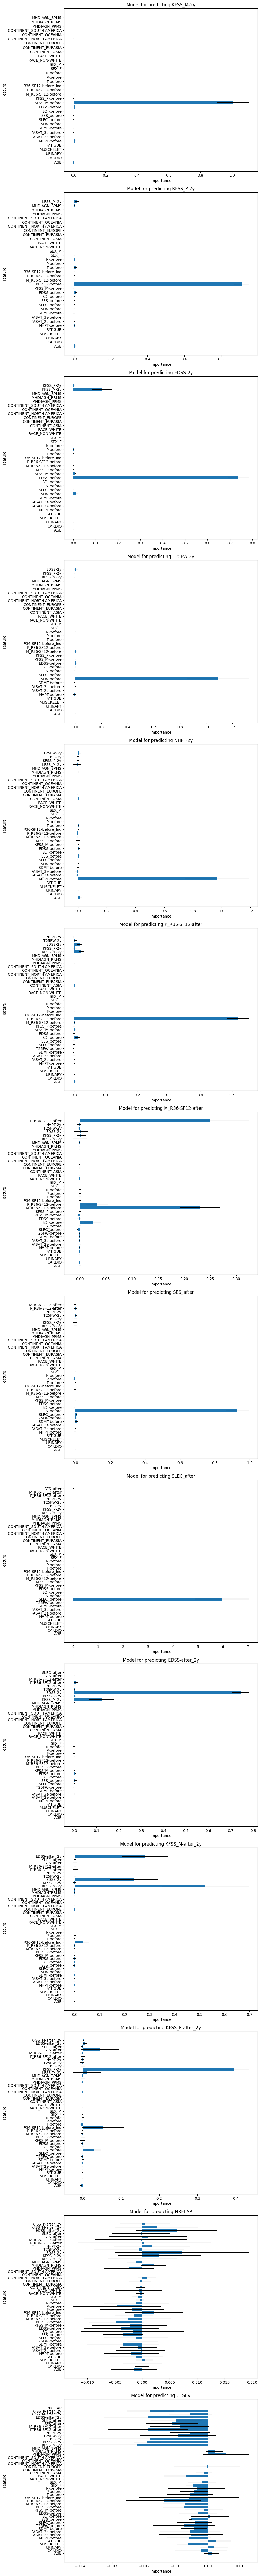

In [79]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(num_models, figsize=(10, 7*num_models), sharex=False)

# Plot importance for each model
for i, (imp, std) in enumerate(zip(averaged_importances.values(), importance_std.values())):
    axs[i].barh(feature_names_for_model[:len(imp)], imp, xerr=std) 
    axs[i].set_title("Model for predicting {}".format(variables[i]))  # Insert outcome into title
    axs[i].set_xlabel('Importance')
    axs[i].set_ylabel('Feature')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [80]:
y_test_cv = []
y_pred_cv = []

for j in range(len(y_test_list)):  # 5
    y_test_targ = []
    y_pred_targ = []
    nvar=y_test_list[0].shape[1]

    for i in range(0, nvar):  # or (1, 5)
        missing_rows_mask = y_test_list[j].iloc[:, i].isna()
        y_test = y_test_list[j].iloc[:, i][~missing_rows_mask]
        y_pred = y_pred_list[j].iloc[:, i][~missing_rows_mask]
        
        y_test_targ.append(y_test)
        y_pred_targ.append(y_pred)
    
    y_test_cv.append(y_test_targ)
    y_pred_cv.append(y_pred_targ)
# y_test_cv[fold][outcome]

In [81]:
# Initialize a list to store scores
scores = []
scores_with_std = []

# Iterate over each outcome variable in the folds
for variable_name in variables: 
    variable_scores = []
    
    # Compute scores for the variable across all folds
    for fold_index in range(len(y_test_cv)):
        y_test = y_test_cv[fold_index][variables.index(variable_name)] 
        y_pred = y_pred_cv[fold_index][variables.index(variable_name)] 
        
        # Check if the target variable is numerical or categorical
        if y_test.dtype.kind in 'bifc':
            score = r2_score(y_test, y_pred)
        else:
            score = accuracy_score(y_test, y_pred)
                  
        variable_scores.append(score)
    
    # Compute the average score for the variable across all folds
    variable_avg_score = np.mean(variable_scores)
    # Compute the standard deviation for the variable across all folds
    variable_std_score = np.std(variable_scores)
    scores_with_std.append((variable_name, variable_avg_score, variable_std_score))

# Print the scores with average and standard deviation along with variable names
print("Scores for each outcome (chain - predicted values):")
for variable_name, avg_score, std_score in scores_with_std:
    print(f"{variable_name}: {avg_score:.2f} (± {std_score:.2f})")

Scores for each outcome (chain - predicted values):
KFSS_M-2y: 0.81 (± 0.01)
KFSS_P-2y: 0.75 (± 0.02)
EDSS-2y: 0.88 (± 0.02)
T25FW-2y: 0.71 (± 0.09)
NHPT-2y: 0.56 (± 0.07)
P_R36-SF12-after: 0.69 (± 0.04)
M_R36-SF12-after: 0.54 (± 0.02)
SES_after: 0.69 (± 0.04)
SLEC_after: 0.67 (± 0.03)
EDSS-after_2y: 0.74 (± 0.04)
KFSS_M-after_2y: 0.65 (± 0.03)
KFSS_P-after_2y: 0.50 (± 0.05)
NRELAP: 0.64 (± 0.02)
CESEV: 0.52 (± 0.04)


### Propagate true values

Still need to fix clf in chaining.py for propagate="true" -- do not run the code below, it won't work

In [82]:
y_pred_list = []
y_test_list = []

for i in range(0, N_FOLDS): 
    Xi_train = featuresM_cv[featuresM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    Xi_test = featuresM_cv[featuresM_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    yi_train = targetsM_cv[targetsM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    yi_test = targets_cv[targets_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    y_test_list.append(pd.DataFrame(yi_test, columns=yi_test.columns, index=yi_test.index))

    chain = Chain(
        model_reg=RandomForestRegressor(random_state=random_state),
        model_clf=RandomForestClassifier(random_state=random_state),
        propagate="true", #RUN MODELS IN A CHAIN
    )
    chain.fit(Xi_train, yi_train, target_types=None) #["reg","reg","reg","reg","reg","reg","reg","reg","reg","clf","clf"]
    y_pred = chain.predict(Xi_test)
    y_pred_list.append(pd.DataFrame(y_pred, columns=yi_test.columns, index=yi_test.index))
    print("Done with evaluating on CV Fold {}".format(i+1))

KeyboardInterrupt: 

In [ ]:
y_test_cv = []
y_pred_cv = []

for j in range(len(y_test_list)):  # 5
    y_test_targ = []
    y_pred_targ = []
    nvar=y_test_list[0].shape[1]

    for i in range(0, nvar):  # or (1, 5)
        missing_rows_mask = y_test_list[j].iloc[:, i].isna()
        y_test = y_test_list[j].iloc[:, i][~missing_rows_mask]
        y_pred = y_pred_list[j].iloc[:, i][~missing_rows_mask]
        
        y_test_targ.append(y_test)
        y_pred_targ.append(y_pred)
    
    y_test_cv.append(y_test_targ)
    y_pred_cv.append(y_pred_targ)
# y_test_cv[fold][outcome]

In [ ]:
# Initialize a list to store scores
scores = []
scores_with_std = []

# Iterate over each outcome variable in the folds
for variable_name in variables: 
    variable_scores = []
    
    # Compute scores for the variable across all folds
    for fold_index in range(len(y_test_cv)):
        y_test = y_test_cv[fold_index][variables.index(variable_name)] 
        y_pred = y_pred_cv[fold_index][variables.index(variable_name)] 
        
        # Check if the target variable is numerical or categorical
        if y_test.dtype.kind in 'bifc':
            score = r2_score(y_test, y_pred)
        else:
            score = accuracy_score(y_test, y_pred)
                  
        variable_scores.append(score)
    
    # Compute the average score for the variable across all folds
    variable_avg_score = np.mean(variable_scores)
    # Compute the standard deviation for the variable across all folds
    variable_std_score = np.std(variable_scores)
    scores_with_std.append((variable_name, variable_avg_score, variable_std_score))

# Print the scores with average and standard deviation along with variable names
print("Scores for each outcome (chain - true values):")
for variable_name, avg_score, std_score in scores_with_std:
    print(f"{variable_name}: {avg_score:.2f} (± {std_score:.2f})")

Scores for each outcome (chain - true values):
KFSS_M-2y: 0.81 (± 0.01)
KFSS_P-2y: 0.75 (± 0.02)
EDSS-2y: 0.88 (± 0.01)
T25FW-2y: 0.72 (± 0.10)
NHPT-2y: 0.54 (± 0.07)
P_R36-SF12-after: 0.69 (± 0.04)
M_R36-SF12-after: 0.55 (± 0.02)
SES_after: 0.69 (± 0.05)
SLEC_after: 0.66 (± 0.03)
EDSS-after_2y: 0.74 (± 0.04)
KFSS_M-after_2y: 0.65 (± 0.03)
KFSS_P-after_2y: 0.52 (± 0.05)
NRELAP: 0.59 (± 0.02)
CESEV: 0.50 (± 0.04)


In [ ]:
# Initialize dictionaries to store the averaged importances and their standard deviations for each model
averaged_importances = {}
importance_std = {}

# Iterate over each model
for model_index in range(len(importances_list[0])):
    # Initialize lists to store importances for the current model
    model_importances = []
    
    # Iterate over each fold
    for fold_index in range(len(importances_list)):
        # Append importances for the current fold and model to the list
        model_importances.append(importances_list[fold_index][model_index])
    
    # Calculate the mean importances for the current model
    averaged_importances[model_index] = np.mean(model_importances, axis=0)
    
    # Calculate the standard deviation of importances for the current model
    importance_std[model_index] = np.std(model_importances, axis=0)